In [35]:
import os
from dotenv import load_dotenv
load_dotenv()

GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [39]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [36]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [66]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)

retriever = vectorstore.as_retriever()

In [67]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

#### Let's look into the retriever grader

In [68]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [69]:
# Prompt
system = """You are a grader checking if a document is relevant to a user’s question.The check has to be done very strictly..  
If the document has words or meanings related to the question, mark it as relevant.  
Give a simple 'yes' or 'no' answer to show if the document is relevant or not."""
    
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [70]:
retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.get_relevant_documents(question)

In [71]:
doc_txt = docs[1].page_content

In [72]:
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


### let's look into the data generation 

In [73]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")

In [74]:
prompt.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [75]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [76]:
rag_chain = prompt | llm

In [77]:
# Run
generation = rag_chain.invoke({"context": docs, "question": question})

In [78]:
generation

AIMessage(content='LLM-powered agents utilize both short-term and long-term memory.  Short-term memory is handled through in-context learning, while long-term memory often involves an external vector store for information retrieval.  This allows agents to retain and recall information over extended periods.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-8db42adb-4bef-4705-8ff3-f556c57800f7-0', usage_metadata={'input_tokens': 2094, 'output_tokens': 58, 'total_tokens': 2152, 'input_token_details': {'cache_read': 0}})

### Hallucination Grader

In [79]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

In [80]:
# Prompt
system = """You are a grader checking if an LLM generation is grounded in or supported by a set of retrieved facts.  
Give a simple 'yes' or 'no' answer. 'Yes' means the generation is grounded in or supported by a set of retrieved the facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

In [81]:
hallucinations_grader = hallucination_prompt | structured_llm_grader
hallucinations_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

#### Answer Grader

In [82]:
### Answer Grader
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

### Question Re-writer

In [ ]:
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vector store retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
     
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What are the different types of agent memory and how do they function?'

In [ ]:
better_question = question_rewriter.invoke({"question":question})

### From here the Langgraph workflow will start

In [84]:
from typing import List
from typing_extensions import TypedDict
class AgentState(TypedDict):
    question: str
    generation: str
    documents: List[str]

In [85]:
def retrieve(state:AgentState):
    print("----RETRIEVE----")
    question=state['question']
    documents=retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

In [86]:
def grade_documents(state:AgentState):
    print("----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----")
    question = state['question']
    documents = state['documents']
    
    filtered_docs = []
    for doc in documents:
        score=retrieval_grader.invoke({"question":question, "document":doc})
        grade=score.binary_score
        
        if grade=='yes':
            print("----GRADE: DOCUMENT RELEVANT----")
            filtered_docs.append(doc)
        else:
            print("----GRADE: DOCUMENT NOT RELEVANT----")
            continue
    return {"documents": filtered_docs, "question": question}
            
            

In [87]:
def decide_to_generate(state:AgentState):
    print("----ACCESS GRADED DOCUMENTS----")
    state["question"]
    filtered_documents = state["documents"]
    
    if not filtered_documents:
        print("----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----")
        return "transform_query"
    else:
        print("----DECISION: GENERATE----")
        return "generate"
    

In [88]:
def generate(state:AgentState):
    print("----GENERATE----")
    question=state["question"]
    documents=state["documents"]
    
    generation = rag_chain.invoke({"context": documents,"question":question})
    return {"documents":documents,"question":question,"generation":generation}

In [89]:
def transform_query(state:AgentState):
    question=state["question"]
    documents=state["documents"]
    
    better_question = question_rewriter.invoke({"question":question})
    return {"documents":documents,"question":better_question}

In [90]:
import pprint
def grade_generation_vs_documents_and_question(state:AgentState):
    print("---CHECK HELLUCINATIONS---")
    question= state['question']
    documents = state['documents']
    generation = state["generation"]
    
    score = hallucinations_grader.invoke({"documents":documents,"generation":generation})
    
    grade = score.binary_score
    
    #Check hallucinations
    if grade=='yes':
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        
        print("---GRADE GENERATION vs QUESTION ---")
        
        score = answer_grader.invoke({"question":question,"generation":generation})
        
        grade = score.binary_score
        
        if grade=='yes':
            print("---DECISION: GENERATION ADDRESS THE QUESTION ---")
            return "useful"
        else:
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
    

In [91]:
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)
workflow.add_node("Docs_Vector_Retrieve", retrieve)
workflow.add_node("Grading_Generated_Documents", grade_documents) 
workflow.add_node("Content_Generator", generate)
workflow.add_node("Transform_User_Query", transform_query)

In [92]:
workflow.add_edge(START, "Docs_Vector_Retrieve")

In [93]:
workflow.add_edge("Docs_Vector_Retrieve","Grading_Generated_Documents")

In [94]:
workflow.add_conditional_edges("Grading_Generated_Documents",
                            decide_to_generate,
                            {
                            "generate": "Content_Generator",
                            "transform_query": "Transform_User_Query"
                            }
                            )

In [95]:
workflow.add_conditional_edges("Content_Generator",
                            grade_generation_vs_documents_and_question,
                            {
                            "useful": END,
                            "not useful": "Transform_User_Query",
                            }
)


In [96]:
workflow.add_edge("Transform_User_Query", "Docs_Vector_Retrieve")

In [97]:
app = workflow.compile()

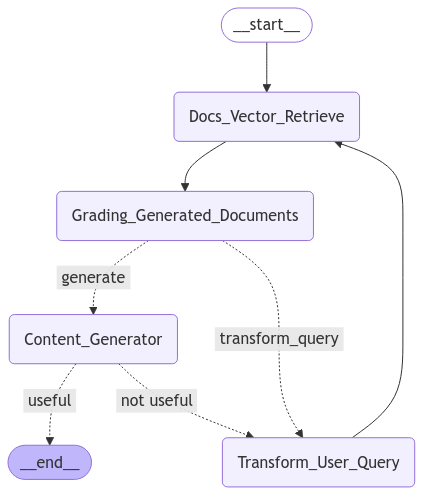

In [98]:
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [99]:
inputs = {"question": "Explain how the different types of agent memory work?"}

In [100]:
app.invoke(inputs)

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION ADDRESS THE QUESTION ---


{'question': 'Explain how the different types of agent memory work?',
 'generation': AIMessage(content='Short-term memory uses in-context learning,  while long-term memory retains information over extended periods using external storage like a vector store for fast retrieval.  This allows the agent to learn from past experiences and access a broader range of information.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-bdd7c9d5-9c9c-499d-84a4-924aa4fd78e6-0', usage_metadata={'input_tokens': 2078, 'output_tokens': 51, 'total_tokens': 2129, 'input_token_details': {'cache_read': 0}}),
 'documents': [Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well

In [108]:
inputs = {"question": "who is a prompt engineering?"}

In [109]:
app.invoke(inputs)

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----
----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS-

{'question': 'What are the core principles and essential skills for effective prompt engineering?',
 'generation': AIMessage(content="Core principles of effective prompt engineering include alignment and model steerability, aiming to guide the Large Language Model (LLM) behavior without modifying its weights.  Essential skills involve experimentation and iterative refinement, as the effectiveness of methods varies across models.  It's an empirical process requiring heuristics.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d435bfe3-9853-4ef7-91ba-bb621be9ca25-0', usage_metadata={'input_tokens': 1033, 'output_tokens': 59, 'total_tokens': 1092, 'input_token_details': {'cache_read': 0}}),
 'documents': [Document(metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired o

In [110]:
inputs = {"question": "what is role of data structure while creating agentic pattern?"}

In [111]:
app.invoke(inputs)

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----
----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----ACCESS G

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


----GRADE: DOCUMENT NOT RELEVANT----


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


ResourceExhausted: 429 Resource has been exhausted (e.g. check quota).